# 09 Visual Place Recognition (VPR)

___

## Motivation

#### What is Visual Place Recognition (VPR)?

![](assets/vpr_overview.jpeg)

*Image retrieved from: https://www.sciencedirect.com/science/article/abs/pii/S003132032030563X*

You'll learn more about VPR in detail in this week's lecture! You can also find out more with this recent [handy tutorial covering VPR](https://arxiv.org/pdf/2303.03281.pdf).

#### [Question] Can you think of some useful applications of VPR? Brainstrom and discuss!

#### [Question] Can you sketch out an approach how we can perform VPR? Brainstorm and discuss!

___

## Preliminary

In [29]:
#Import
import numpy as np
import cv2
import os
import random

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree

In [30]:
#Setup paths
database_path = r'./T4imgs/database/'
query_path = r"./T4imgs/queries/"
num_of_imgs = 1

In [31]:
# Read query (target images)
query_imgs = []

query_paths = os.listdir(query_path)

for i in query_paths:
    # Read
    img = cv2.imread(os.path.join(query_path, i))
    # Store
    query_imgs.append(img[:, :, ::-1]) # BGR to RGB

In [32]:
# Read a few random images as well
sampled_imgs = []
num_samples = len(query_imgs)
sample_paths = random.sample(os.listdir(database_path), num_samples)

for i in sample_paths:
    # Read
    img = cv2.imread(os.path.join(database_path, i))
    # Store
    sampled_imgs.append(img[:, :, ::-1]) # BGR to RGB

## Extract and Aggregate SIFT Feature of the Database

1. **Extract** and **Aggregate** features from all the database images. I use SIFT here, but SURF or ORB may also work. Every step, we directly read an image from the SSD, extract features with help of OpenCV's implementation of SIFT, aggregate the extracted feature into a big list `database_entire_des` that would store all the features from all the images, by taking advantage of python's `extend` so we are not creating nested array.
    - It's tempting to store all the loaded images or computed (SIFT) feature and retrieve them later from RAM. But my experiment showed that it's actually faster if we just load them and re-compute (SIFT) feature whenever we need any one of these two, as SSD + CPU doing heavylifting is faster than CPU + RAM doing heavylifing. Anyway, I didn't store the computed SIFT or loaded images anywhere
    
**Note**: `We shall subsample the dataset in the following steps due to save on compute required. You should run with the hold dataset to get the optimal result!`


In [33]:
# Create SIFT feature extractor
sift = cv2.SIFT_create()

In [34]:
# Use slim = True for lower compute / memory usage
def extract_aggregate_features(extractor, folder_path, slim = False, periodicity = 5):
    all_descriptors = list()
    # database_features = dict()

    # Determine images to read
    cadence = 1 if not slim else periodicity
    img_paths = os.listdir(folder_path)[::cadence]

    # Read and extract features
    for img_name in tqdm(img_paths):
        # Read
        img = cv2.imread(folder_path + img_name)
        # Extract features
        kp, des = extractor.detectAndCompute(img, None)
        # Store
        all_descriptors.extend(des)
        # database_features[img_name] = des
        
    all_descriptors = np.array(all_descriptors)
    return all_descriptors, img_paths

In [35]:
# Assemble database and extract features
slim = True
database_entries, img_paths = extract_aggregate_features(sift, database_path, slim = slim, periodicity = 5)

  4%|▍         | 255/5720 [00:01<00:41, 130.50it/s]

100%|██████████| 5720/5720 [00:43<00:00, 130.37it/s]


## Clustering the Features using K-mean

2. **Clustering** the entire list of features by using scikit-learn's KMeans class. 
    - We cluster them into 16 class and only run it 1 times, because in our case we are actually finding the identical image in the database given a query, and the image is very small itself. In the real world the query image may be larger and not even in the database, so we can only find similar one, we would need more classes (64 or 256) and more run of the clustering algorithm to get the best performing one (like 10 times) so the generated codebook is more robust.
    - I turned off the text display for training so it's less verbose.

In [36]:
# Clustering the entire bag of descriptor
# codebook = KMeans(n_clusters = 64, init = 'k-means++', n_init = 10, verbose = 1).fit(database_entries)
codebook = KMeans(n_clusters = 16, init = 'k-means++', n_init = 1, verbose = 1).fit(database_entries) # save time

Initialization complete
Iteration 0, inertia 223208996864.0
Iteration 1, inertia 139905269760.0
Iteration 2, inertia 137813049344.0
Iteration 3, inertia 136811610112.0
Iteration 4, inertia 136060747776.0
Iteration 5, inertia 135512211456.0
Iteration 6, inertia 135178018816.0
Iteration 7, inertia 134987128832.0
Iteration 8, inertia 134864265216.0
Iteration 9, inertia 134778224640.0
Iteration 10, inertia 134715793408.0
Iteration 11, inertia 134663192576.0
Iteration 12, inertia 134609690624.0
Iteration 13, inertia 134567698432.0
Iteration 14, inertia 134532808704.0
Iteration 15, inertia 134500188160.0
Iteration 16, inertia 134471729152.0
Iteration 17, inertia 134447570944.0
Iteration 18, inertia 134428008448.0
Iteration 19, inertia 134411018240.0
Iteration 20, inertia 134399057920.0
Iteration 21, inertia 134385508352.0
Iteration 22, inertia 134374268928.0
Iteration 23, inertia 134367477760.0
Iteration 24, inertia 134361448448.0
Iteration 25, inertia 134354796544.0
Iteration 26, inertia 13

## Compute VLAD Feature for Every Database Image

3. **Compute** VLAD feature for every image. We first load all images, compute their (SIFT) features on the fly as it's faster like I said before. We then use this feature to compute the corresponding VLAD feature of this image, and append it to the list `database_VLAD`, where each element is a VLAD feature.
    - We compute VLAD by compute the sum of residue to each centroid and concatenate these vectors.
    - We normalize the VLAD vector using square root normalization and L2 normalization.
    - My implementation of VLAD calculation is adapted from here: https://github.com/jorjasso/VLAD/blob/eeaad96c33aea9c11bceb285ba5cdabba9fb663f/VLADlib/VLAD.py#L177
4. At the same time we create a list `database_name` used to hold all the names of database image. Because we are inserting name to this list at the same time we create and append a VLAD feature, we now have a one-to-one mapping between `database_VLAD` and `database_name`, i.e. two list is pointing to the same image if given two identical index.

In [37]:
# VLAD
def get_VLAD(X, codebook):
    predictedLabels = codebook.predict(X)
    centroids = codebook.cluster_centers_
    labels = codebook.labels_
    k = codebook.n_clusters

    m, d = X.shape
    VLAD_features = np.zeros((k, d))

    # Computing the residuals
    for i in range(k):
        # Check if the cluster is empty
        if np.sum(predictedLabels == i) > 0:
            VLAD_features[i] = np.sum(X[predictedLabels == i, :] - centroids[i], axis = 0)
    
    VLAD_features = VLAD_features.flatten()
    # Power normalization
    VLAD_features = np.sign(VLAD_features) * np.sqrt(np.abs(VLAD_features))

    # L2 normalization
    VLAD_features = VLAD_features / np.linalg.norm(VLAD_features)
    return VLAD_features


In [38]:
# Initialize and build VLAD collection
database_VLAD = list()
database_name = list()

period = 1 if not slim else 5

for img_name in tqdm(img_paths):
# for img_name in tqdm(img_paths[::period]):
    # Read
    img = cv2.imread(database_path + img_name)
    # Extract features
    kp, des = sift.detectAndCompute(img, None)
    # Get VLAD
    VLAD = get_VLAD(des, codebook)
    # Store
    database_VLAD.append(VLAD)
    database_name.append(img_name)

database_VLAD = np.array(database_VLAD)

100%|██████████| 5720/5720 [00:47<00:00, 120.00it/s]


## Indexing all the VLAD Features

5. **Indexing** all the VLAD features by creating a `BallTree` of the list `database_VLAD`. This is not essential because we can also do a pair-wise comparison, but BallTree saves a lot of time when retrieving the item that has the smallest distance to the query. This is not essential so I will skip explaining Balltree. But generally, it's a efficient indexing method that performs better when the data is high dimensional, comparing to its alternative KD-Tree
    - I am using L2 distance as the measure between VLAD features. But the choice doesn't matter in this specific problem, because again, we are finding the exact same picture so the distance, no matter what, would be 0, since SIFT and VLAD are both not randomized, so for the same image they would generate the same feature vector.

In [39]:
# Query model
tree = BallTree(database_VLAD, leaf_size = 60)

## Query

6. Compute (SIFT) feature of all the query images, and then compute VLAD feature accordingly, using the same clustering as the database. We then get the VLAD feature of this 5 query images. We then find the images in database whose VLAD feature distance to these query images are 0, respectively.
    - Here we are finding only the top 1 match in `tree.query`, because we know the distance will be 0 as the image in query will have an identical one in the database. In the real world when finding similar images, we will need more matching like 3 or 5, and manually or use some other algorithm to further identify the most similar one

In [40]:
# Fetch
value_list = list()

sorted_query_path = os.listdir(query_path)
sorted_query_path.sort()

for img_name in tqdm(sorted_query_path):
    query = cv2.imread(query_path + img_name)
    q_kp, q_des = sift.detectAndCompute(query, None)
    q_VLAD = get_VLAD(q_des, codebook).reshape(1, -1)

    # Only want the cloest one
    dist, index = tree.query(q_VLAD, k = num_of_imgs)

    # Index is an array of array of 1
    value_name = database_name[index[0][0]]
    value_list.append(value_name)

100%|██████████| 5/5 [00:00<00:00, 31.30it/s]


7. Below is the matches in the database for all the query images, in the order from query1.png to query5.png

> ['image1633.png',
 'image2882.png',
 'image5790.png',
 'image26588.png',
 'image14195.png']

In [41]:
value_list

['image1633.png',
 'image2882.png',
 'image5790.png',
 'image26588.png',
 'image14195.png']

Now let's plot and compare the ground truth query images vs the ones we've just fetched via VPR!

In [42]:
recovered_imgs = [cv2.imread(os.path.join(database_path, i))[:, :, ::-1] for i in value_list]

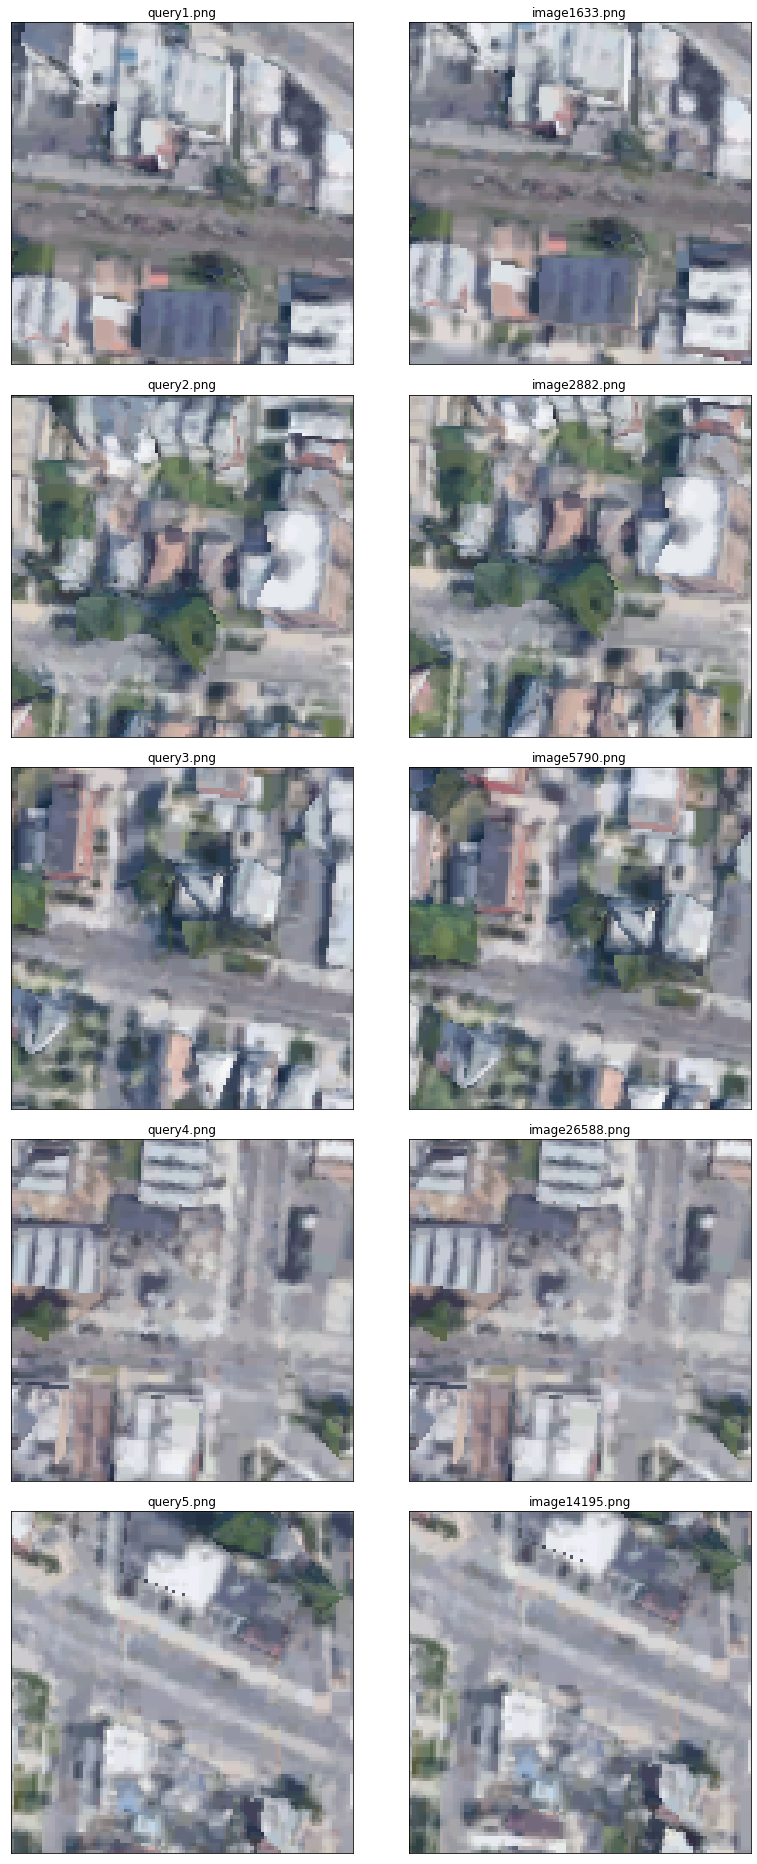

In [43]:
# Plot
fig,axs = plt.subplots(num_samples,2,figsize=(12,26))

for idx,(i,j) in enumerate(zip(query_imgs, recovered_imgs)):
    
    #Plot
    axs[idx,0].imshow(i)
    axs[idx,1].imshow(j)
    
    #Set title to ref img names
    axs[idx,0].title.set_text(query_paths[idx])
    axs[idx,1].title.set_text(value_list[idx])
    
    #Tidy things up
    axs[idx,0].set_yticks([])
    axs[idx,0].set_xticks([])
    axs[idx,1].set_yticks([])
    axs[idx,1].set_xticks([])
    
fig.tight_layout()

____
# Homework

For the homework, you will repeat the above tutorial, but with the [Oxford New College Dataset](https://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/data.html) instead.

The following is a preview of the **query** (left column) images and some random samples (right column) from the sequence.

#### Preview
![](assets/homework_preview.png)

Given the above, you need to 

1. Use VPR to find the 8 query images as shown above, and the images can be found under the `NewCollege_dataset` folder.
2. Once you're done, you should retrieved a list of **image names** and their corresponding **distance** metric from VLAD. _Provide a **screenshot** with **both the list of image names you retrieved AND their corresponding distance metrics** in your submission_.
3. Provide and submit your entire homework notebook as well.

For each correctly retrieved image, you will get 0.5 marks. If you managed to retrieve all 8 images correctly, you will get the full 4 marks.

You can submit your homework here: https://forms.gle/TV4eCcLnvJepfFuXA

___
